In [1]:
import sys
sys.path.append("../../src")
import os
import datetime
import pandas as pd
import numpy as np
from wsindy_utils import library_size
from training_wsindy import train_network
from error_utils import *
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from time import time
import matplotlib.pyplot as plt
import pickle 
import subprocess as sp
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 15265
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 15048
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 223
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 15254


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,
                                                                              visible_device_list='1'))

#### Load data

In [4]:
# load initial training dataset
p1_train = np.linspace(0.9, 1.1, 4)
p2_train = np.linspace(1.0, 1.2, 4)
num_train = p1_train.size * p2_train.size  # initial number of training +data
tstop = 5.0
nx = 64
dt = 0.005 * 4
nt = int(tstop/dt) + 1
train_data = pickle.load(open(f"/usr/workspace/he10/data/Vlasov1D1V/{num_train}_m{nx}_tstop{tstop:.2f}_nt{nt}.p", "rb"))
num_wsindy = len(train_data['data'])
input_dim = train_data['data'][0]['x'].shape[1]

for i in range(num_wsindy):
    print(f"case {i}: params: {train_data['param'][i]}, x shape: {train_data['data'][i]['x'].shape}")
    
# load dataset of discrete parameter space for greedy sampling
p1_test = np.linspace(0.9, 1.1, 4)
p2_test = np.linspace(1.0, 1.2, 4)
num_test = p1_test.size * p2_test.size # number of cases in the discrete parameter space
test_data = pickle.load(open(f"/usr/workspace/he10/data/Vlasov1D1V/{num_test}_m{nx}_tstop{tstop:.2f}_nt{nt}.p", "rb"))

case 0: params: [0.9 1. ], x shape: (1001, 4096)
case 1: params: [1. 1.], x shape: (1001, 4096)
case 2: params: [1.1 1. ], x shape: (1001, 4096)
case 3: params: [0.9 1.1], x shape: (1001, 4096)
case 4: params: [1.  1.1], x shape: (1001, 4096)
case 5: params: [1.1 1.1], x shape: (1001, 4096)
case 6: params: [0.9 1.2], x shape: (1001, 4096)
case 7: params: [1.  1.2], x shape: (1001, 4096)
case 8: params: [1.1 1.2], x shape: (1001, 4096)


In [5]:
grid1, grid2 = np.meshgrid(p1_train, p2_train)
train_param = np.hstack((grid1.flatten().reshape(-1,1), grid2.flatten().reshape(-1,1)))
grid1, grid2 = np.meshgrid(p1_test, p2_test)
test_param = np.hstack((grid1.flatten().reshape(-1,1), grid2.flatten().reshape(-1,1)))

train_idx = []
for i in range(num_test):
    for j in range(num_train):
        if np.abs(test_param[i,0]-train_param[j,0]) < 1e-8 and \
        np.abs(test_param[i,1]-train_param[j,1]) < 1e-8:
            train_idx.append(i)
print(train_idx)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


(0.0, 6.234097921967246, -7.0, 6.890625)

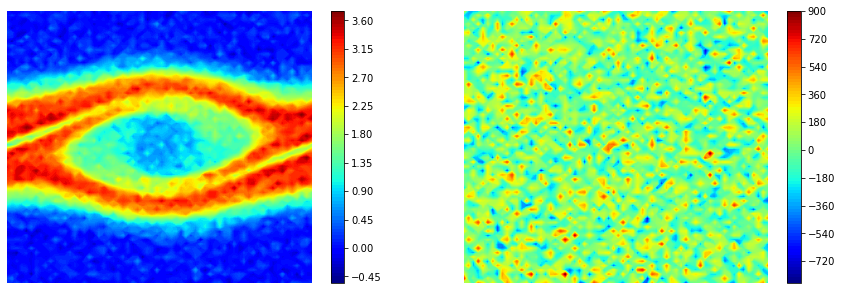

In [6]:
nx = 64
nv = 64
x_min = 0
x_max = 6.2340979219672459E+00
v_min = -7
v_max = 6.8906250000000000E+00
x_mesh = np.linspace(x_min, x_max, nx)
v_mesh = np.linspace(v_min, v_max, nv)
x_mesh, v_mesh = np.meshgrid(x_mesh, v_mesh)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
plt.contourf(x_mesh, v_mesh, train_data['data'][0]['x'][-1].reshape(nx, nv), 100, cmap=plt.cm.jet)
plt.colorbar()
plt.axis('off')

ax = fig.add_subplot(1,2,2)
plt.contourf(x_mesh, v_mesh, train_data['data'][0]['dx'][-1].reshape(nx, nv), 100, cmap=plt.cm.jet)
plt.colorbar()
plt.axis('off')

## Set up model and training parameters

In [7]:
params = {}

params['seed'] = 1 # random seed
params['config'] = config
params['num_wsindy'] = num_wsindy
params['param'] = train_data['param']
params['train_idx'] = train_idx
params['input_dim'] = input_dim
params['latent_dim'] = 3
params['poly_order'] = 1
params['include_sine'] = False
params['include_cosine'] = False
params['include_costant'] = True
params['model_order'] = 1
params['library_dim'] = library_size(params['latent_dim'], params['poly_order'], 
                                     params['include_sine'], params['include_cosine'], 
                                     params['include_costant'])

# sequential thresholding parameters
params['sequential_thresholding'] = False
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
params['coefficient_initialization'] = 'normal'

# loss function weighting
params['loss_weight_decoder'] = 1
params['loss_weight_wsindy_x'] = 1e1
params['loss_weight_wsindy_z'] = 1e2
params['loss_weight_wsindy_regularization'] = 1e-5
params['diff'] = 'symb' # 'symb': symbolic diff (only for fully connected Autoencoder), 'auto': automatic diff
params['activation'] = 'relu'
params['widths'] = [1000,100,50,50,50]

# training parameters
params['L'] = 12
params['epoch_size'] = train_data['data'][0]['x'].shape[0]
num_batch = 1
params['batch_size'] = (params['epoch_size'] + 2 * (num_batch-1) * params['L']) // num_batch # for N batches: (epoch_size + 2*(N-1)*L)/N
params['batch_overlap'] = 2*params['L']
params['learning_rate'] = 1e-4

params['fig_path'] = os.getcwd() + '/fig/nDI16/'
if not os.path.exists(params['fig_path']):
    os.makedirs(params['fig_path'])
params['print_progress'] = True
params['print_frequency'] = 200
params['save_frequency'] = 10000

# training epochs
params['max_epochs'] = 400000  # max number of training epochs

# Greedy sampling algorithm
params['update_epoch'] = 400000 # Greedy sampling frequency
params['tol'] = 0.001          # initial tolerance of the maximum error indicator in the parameter space; it will be updated during training using the prescribed `adaptive` method
params['tol2'] = 5             # initial tolerance of the maximum relative error in the parameter space
params['wsindy_max'] = 16       # max number of local DIs; if tolerance is used as a termination criterior, set it as None
params['convex_knn'] = 1       # the number nearest local DIs used for convex interpolation during Greedy sampling
params['test_data'] = test_data # dataset of the discrete parameter space
params['test_param'] = np.hstack((p1_test.reshape(-1,1), p2_test.reshape(-1,1))) # parameters of the discrete parameter space
params['num_test'] = num_test  # the number of parameter cases of the discrete parameter space
params['coeff_exist'] = False  # whether to initialize model coefficients with pescribed values, set as False
params['retrain'] = False      # whether to retrain the model; set as False for training a new model

# Error indicator:
# 1: max relative error (if test data is available); 
# 2: residual norm for 1D Burgers eqn; 
# 3: residual norm for 2D Burgers eqn; 
# 4: residual norm for time dependent heat conduction (MFEM example 16); 
# 5: residual norm for radial advection (MFEM example 9)
params['err_type'] = 1                            
params['subsize'] = int(1.0 * num_test) # initial random subset size, the number of randomly selected cases for Greedy sampling
params['subsize_max'] = 100              # maximum random subset size in percentage

# Adaptive approach for tol of error indicator:
# 'mean': use mean ratios between error indicator and max relative errors
# 'reg_mean': use linear regression line
# 'reg_max': use linear regression line shifted by std to upper bound
# 'reg_min': use linear regression line shifted by std to lower bound, more conservative
params['adaptive'] = 'reg_max'                      

# PDE parameters
params['pde'] = {}
params['pde']['dt'] = dt

In [8]:
if params['retrain']: # for retraining the model
    save_name = 'vlasov_2024_03_07_22_15_44'
    params = pickle.load(open(params['fig_path'] + save_name + '_params.pkl', 'rb'))
    params['retrain'] = True
    params['coeff_exist'] = True  # flag to indicate whether to initialize model coefficients with pescribed values
    params['save_name'] = save_name
    params['max_epochs'] = 100000
    params['update_epoch'] = 100000
    # params['save_frequency'] = 5000
    # params['wsindy_max'] = 36       # max number of local DIs; if tolerance is used as a termination criterior, set it as None
    # num_batch = 2
    # params['batch_size'] = (params['epoch_size'] + 2 * (num_batch-1) * params['L']) // num_batch # for N batches: (epoch_size + 2*(N-1)*L)/N
    # params['testing_losses'] = []
    # params['learning_rate'] = 1e-4
    # params['loss_weight_wsindy_regularization'] = 1e-5
    
    for i in params['train_idx'][4:]:
        train_data['data'].append(test_data['data'][i])
        train_data['param'].append(test_data['param'][i])

## Training

In [ ]:

df = pd.DataFrame()
timer = []
timer.append(time())

if not params['retrain']:
    params['save_name'] = 'vlasov_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
tf.reset_default_graph()
results_dict = train_network(train_data, params)
df = df.append({**results_dict, **params}, ignore_index=True)
    
timer.append(time())
print(f'training time: {(timer[-1]-timer[0])/60:.2f} mins, {(timer[-1]-timer[0])/3600:.2f} hours')

Instructions for updating:
Use `tf.cast` instead.
* Evaluating
  Time: 0.00 s, Case: [0.9 1. ], Tol: 0.00100, Max Error: -1.000000
Epoch 0
  train loss: 2.4234e+01, decoder: 2.4232e+01, wsindy-x: 7.4231e-02, wsindy-z: 6.7888e-02, wsindy-reg: 7.0541


In [ ]:
# history of validation loss
train_loss = np.array(df['training_losses'][0]).squeeze()
test_loss = np.array(df['testing_losses'][0]).squeeze()

fig, ax1 = plt.subplots(figsize=(9,5))
xt = np.linspace(1,df['num_epochs'][0],train_loss.shape[0])
ax1.plot(xt, train_loss[:,0], 'r', label='Train')
ax1.set_yscale('log')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', color='r', fontsize=16)
ax1.set_xlim(0, df['num_epochs'][0])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
xt = np.linspace(1,df['num_epochs'],test_loss.shape[0])
ax2.plot(xt, test_loss, 'b-o', label='Val')
ax2.set_ylabel('Max Error', color='b', fontsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='y', labelcolor='b')

plt.grid()
plt.tight_layout()
plt.savefig(f"{params['fig_path']}/loss.png")